In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import max_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from statsmodels.graphics.tsaplots import plot_acf
import itertools
import statsmodels.api as sm
import joblib
import time
from statistics import median,mean

In [4]:
plt.style.use('seaborn-v0_8')
plt.style.use('fivethirtyeight')

In [93]:
def report_performance(actual,pred):
    print(f"RMSE: {np.sqrt(mean_squared_error(actual,pred)):.2f}, MAPE: {mean_absolute_percentage_error(actual,pred):.4f}")
    print(f"MAE: {mean_absolute_error(actual,pred):.2f}, MaxE: {max_error(actual,pred):.2f}")
    print(f"MedAE: {median_absolute_error(actual,pred):.2f}, R2: {r2_score(actual,pred):.2f}")
    
def report_mean_r2(df,pred):
    temp_df = df[['center_id','meal_id','num_orders']].copy().reset_index(drop=True)
    temp_pred = np.array(pred)
    r2_scores = []
    for center in centers:
        for meal in meals:
            center_meal_df_indices = temp_df.query('center_id==@center and meal_id==@meal').index
            if len(center_meal_df_indices) > 1:
                center_meal_actual = temp_df.loc[center_meal_df_indices,'num_orders']
                center_meal_pred = temp_pred[center_meal_df_indices]
                r2_scores.append(r2_score(center_meal_actual,center_meal_pred))
    mean_r2 = mean(r2_scores)
    print(f'Mean r2: {mean_r2:.2f}')

## Load data into one table

In [6]:
df_center = pd.read_csv('fulfilment_center_info.csv')
df_meal = pd.read_csv('meal_info.csv')
df_train = pd.read_csv('train.csv')
df = df_train.merge(df_meal,on='meal_id',how='left').merge(df_center,on='center_id',how='left')

In [7]:
df

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,category,cuisine,city_code,region_code,center_type,op_area
0,1379560,1,55,1885,136.83,152.29,0,0,177,Beverages,Thai,647,56,TYPE_C,2.0
1,1466964,1,55,1993,136.83,135.83,0,0,270,Beverages,Thai,647,56,TYPE_C,2.0
2,1346989,1,55,2539,134.86,135.86,0,0,189,Beverages,Thai,647,56,TYPE_C,2.0
3,1338232,1,55,2139,339.50,437.53,0,0,54,Beverages,Indian,647,56,TYPE_C,2.0
4,1448490,1,55,2631,243.50,242.50,0,0,40,Beverages,Indian,647,56,TYPE_C,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456543,1271326,145,61,1543,484.09,484.09,0,0,68,Desert,Indian,473,77,TYPE_A,4.5
456544,1062036,145,61,2304,482.09,482.09,0,0,42,Desert,Indian,473,77,TYPE_A,4.5
456545,1110849,145,61,2664,237.68,321.07,0,0,501,Salad,Italian,473,77,TYPE_A,4.5
456546,1147725,145,61,2569,243.50,313.34,0,0,729,Salad,Italian,473,77,TYPE_A,4.5


In [6]:
df.isna().sum()

id                       0
week                     0
center_id                0
meal_id                  0
checkout_price           0
base_price               0
emailer_for_promotion    0
homepage_featured        0
num_orders               0
category                 0
cuisine                  0
city_code                0
region_code              0
center_type              0
op_area                  0
dtype: int64

In [7]:
df[['week','center_id','meal_id']].duplicated().sum()

0

## Set up data transformers and models

Encode the week with a periodic encoding, using both sin and cos to avoid same-value encoding

In [8]:
def encode_week_sin(x):
    return np.sin(x*2*np.pi/52)
def encode_week_cos(x):
    return np.cos(x*2*np.pi/52)
def encode_week(x):
    return 1.0*x/52.0

Encode the categorical/label/id variables with a one-hot encoder and the numerical variables with a standard scaling encoder.

In [9]:
preprocessor = ColumnTransformer(
    transformers = [
        ('scaler',StandardScaler(),['op_area','checkout_price','base_price']),
        ('onehot',OneHotEncoder(),['center_id','meal_id','category','cuisine','city_code','region_code','center_type']),
        ('week',FunctionTransformer(encode_week),['week'])
        #('week_sin',FunctionTransformer(encode_week_sin),['week']),
        #('week_cos',FunctionTransformer(encode_week_cos),['week'])
    ],
    remainder='passthrough'
)

In [272]:
0.2*144

28.8

In [43]:
meals = list(df_meal['meal_id'])
centers = list(df_center['center_id'])

In [10]:
meals

[1885,
 1993,
 2539,
 1248,
 2631,
 1311,
 1062,
 1778,
 1803,
 1198,
 2707,
 1847,
 1438,
 2494,
 2760,
 2490,
 1109,
 2290,
 1525,
 2704,
 1878,
 2640,
 2577,
 1754,
 1971,
 2306,
 2139,
 2826,
 2664,
 2569,
 1230,
 1207,
 2322,
 2492,
 1216,
 1727,
 1902,
 1247,
 2304,
 1543,
 1770,
 2126,
 1558,
 2581,
 1962,
 1571,
 2956,
 2104,
 2444,
 2867,
 1445]

Save the last 29 weeks (~20% of the dataset) for testing forecasting capability.

## Baseline Model - Forecasting a center's meal orders as the mean of that center's weekly orders for that meal.

In [100]:
df_train_baseline = df[df['week'] <= 116]
df_test_baseline = df[df['week'] > 116]
X_train_baseline = df_train_baseline[['center_id','meal_id']]
y_train_baseline = df_train_baseline['num_orders']
X_test_baseline = df_test_baseline[['center_id','meal_id']]
y_test_baseline = df_test_baseline['num_orders']

In [101]:
baseline_df = pd.concat([X_train_baseline[['center_id','meal_id']],y_train_baseline],axis=1).groupby(by=['center_id','meal_id'],as_index=False).mean()

In [102]:
baseline_df.query('center_id==55 and meal_id==1885')['num_orders'].values[0]

253.29310344827587

In [103]:
def baseline_predict(xtest):
    y_pred = np.zeros(len(xtest))
    for i in range(len(xtest)):
        test_row = xtest.iloc[i,]
        center_id = test_row['center_id']
        meal_id = test_row['meal_id']
        relevant_baseline_row = baseline_df.query(f'center_id=={center_id} and meal_id=={meal_id}')
        if len(relevant_baseline_row) == 1:
            y_pred[i] = relevant_baseline_row['num_orders'].values[0]
        else:
            y_pred[i] = 0
    return y_pred

In [104]:
y_pred_baseline = baseline_predict(X_test_baseline)

In [105]:
report_performance(y_test_baseline,y_pred_baseline)

RMSE: 248.96, MAPE: 0.8088
MAE: 109.75, MaxE: 11916.54
MedAE: 55.61, R2: 0.54


In [55]:
report_mean_r2(df_test_baseline,y_pred_baseline)

Mean r2: -0.99


## Model with entire dataset

In [20]:
num_columns = ['op_area', 'checkout_price', 'base_price']
cat_columns = ['center_id','meal_id','category','cuisine','city_code','region_code','center_type']
df_processed = df.copy()
df_processed = pd.get_dummies(df_processed, columns=cat_columns)

for col in num_columns: 
    col_scaler = StandardScaler().fit(df_processed[col].values.reshape(-1,1))
    df_processed[col] = col_scaler.transform(df_processed[col].values.reshape(-1,1))
df_processed['week'] = FunctionTransformer(encode_week).fit_transform(df_processed['week'].values.reshape(-1,1))

df_train = df_processed[df['week'] <= 116]
df_test = df_processed[df['week'] > 116]
X_train_noshift = df_train.drop(['num_orders','id'],axis=1)
y_train_noshift = df_train['num_orders']
X_test_noshift = df_test.drop(['num_orders','id'],axis=1)
y_test_noshift = df_test['num_orders']

In [529]:
lr_model_noshift = LinearRegression()
lr_model_noshift.fit(X_train_noshift,y_train_noshift)
y_pred = lr_model_noshift.predict(X_test_noshift)
report_performance(y_test_noshift,y_pred)

RMSE: 260.15, MAPE: 1.66
MAE: 149.37, MaxE: 11840.85
R2: 0.49


In [239]:
X_train_sm = sm.add_constant(X_train)
X_test_sm = sm.add_constant(X_test)

X_train_sm = X_train_sm.drop(X_train_sm.filter(like='base_').columns, axis=1)
#X_train_sm = X_train_sm.drop(X_train_sm.filter(like='city_code').columns, axis=1)
X_train_sm = X_train_sm.drop(X_train_sm.filter(like='center_id').columns, axis=1)
#X_train_sm = X_train_sm.drop(X_train_sm.filter(like='meal_id').columns, axis=1)
#X_train_sm = X_train_sm.drop(X_train_sm.filter(like='category').columns, axis=1)
#X_train_sm = X_train_sm.drop(X_train_sm.filter(like='cuisine').columns, axis=1)
#X_train_sm = X_train_sm.drop(X_train_sm.filter(like='region_code').columns, axis=1)
X_train_sm = X_train_sm.drop(X_train_sm.filter(like='center_type').columns, axis=1)

X_test_sm = X_test_sm.drop(X_test_sm.filter(like='base_').columns, axis=1)
#X_test_sm = X_test_sm.drop(X_test_sm.filter(like='city_code').columns, axis=1)
X_test_sm = X_test_sm.drop(X_test_sm.filter(like='center_id').columns, axis=1)
#X_test_sm = X_test_sm.drop(X_test_sm.filter(like='meal_id').columns, axis=1)
#X_test_sm = X_test_sm.drop(X_test_sm.filter(like='category').columns, axis=1)
#X_test_sm = X_test_sm.drop(X_test_sm.filter(like='cuisine').columns, axis=1)
#X_test_sm = X_test_sm.drop(X_test_sm.filter(like='region_code').columns, axis=1)
X_test_sm = X_test_sm.drop(X_test_sm.filter(like='center_type').columns, axis=1)

model = sm.OLS(y_train,X_train_sm)
res = model.fit()
print(res.summary())
y_pred = res.predict(X_test_sm)
report_performance(y_test,y_pred)

                            OLS Regression Results                            
Dep. Variable:             num_orders   R-squared:                       0.469
Model:                            OLS   Adj. R-squared:                  0.469
Method:                 Least Squares   F-statistic:                     3038.
Date:                Thu, 16 Feb 2023   Prob (F-statistic):               0.00
Time:                        11:51:55   Log-Likelihood:            -2.5666e+06
No. Observations:              361348   AIC:                         5.133e+06
Df Residuals:                  361242   BIC:                         5.134e+06
Df Model:                         105                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                 -3.058e+

In [322]:
xgb_model_noshift = xgb.XGBRegressor(n_estimators=200)
xgb_model_noshift.fit(X_train_noshift,y_train_noshift)
y_pred_noshift = xgb_model.predict(X_test_noshift)
report_performance(y_test,y_pred_noshift)

MSE: 29474.15, MAPE: 0.63
MAE: 84.33, MaxE: 9905.11
R2: 0.78


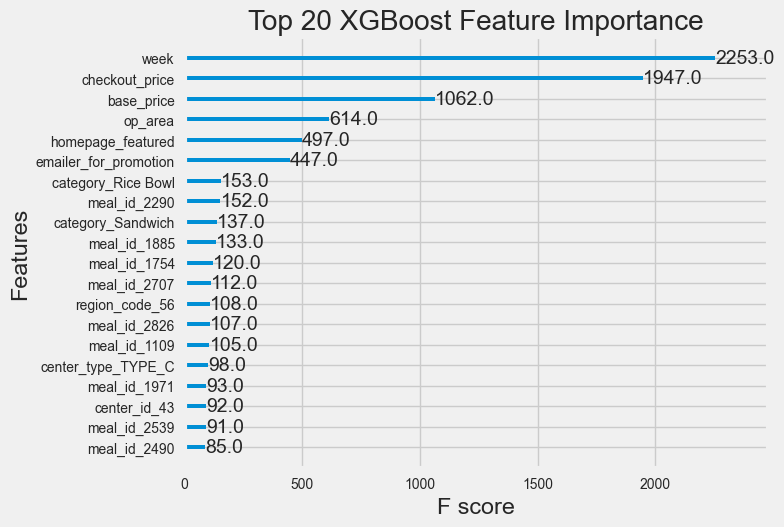

In [476]:
fig,ax = plt.subplots()
xgb.plot_importance(xgb_model_noshift, ax=ax, max_num_features=20)
ax.set_title('Top 20 XGBoost Feature Importance')
plt.tight_layout()
fig.savefig('./figs/importancenoshift.png')

### Add auto-regressive values

Add n total columns of previous values of num_orders for a given center_id and meal_id for 1,2,...,n weeks prior.

In [27]:
def append_previous_orders(df,n):
    y_pred_dict = {f'num_orders_shift{i+1}': np.zeros(len(df)) for i in range(n)}
    for i in range(len(df)):
        curr_row = df.iloc[i,]
        week = curr_row['week']
        center_id = curr_row['center_id']
        meal_id = curr_row['meal_id']
        for j in range(n):
            shifted_row = df.query(f'week=={week-(j+1)} and center_id=={center_id} and meal_id=={meal_id}')
            if len(shifted_row) == 1:
                y_pred_dict[f'num_orders_shift{j+1}'][i] = df.at[shifted_row.index[0],'num_orders']
    return pd.concat([df,pd.DataFrame(y_pred_dict)],axis=1)

In [11]:
df_AR.loc[1,'week']

1

In [29]:
df_AR = append_previous_orders(df,6)

In [23]:
df_AR = pd.read_csv('./df_AR.csv')

In [147]:
df_AR.columns

Index(['id', 'week', 'center_id', 'meal_id', 'checkout_price', 'base_price',
       'emailer_for_promotion', 'homepage_featured', 'num_orders', 'category',
       'cuisine', 'city_code', 'region_code', 'center_type', 'op_area',
       'num_orders_shift1', 'num_orders_shift2', 'num_orders_shift3',
       'num_orders_shift4', 'num_orders_shift5', 'num_orders_shift6'],
      dtype='object')

In [41]:
df_AR[df_AR['num_orders_shift1'].isin([np.inf,-np.inf])]

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,category,...,city_code,region_code,center_type,op_area,num_orders_shift1,num_orders_shift2,num_orders_shift3,num_orders_shift4,num_orders_shift5,num_orders_shift6


In [30]:
df_AR

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,category,...,city_code,region_code,center_type,op_area,num_orders_shift1,num_orders_shift2,num_orders_shift3,num_orders_shift4,num_orders_shift5,num_orders_shift6
0,1379560,1,55,1885,136.83,152.29,0,0,177,Beverages,...,647,56,TYPE_C,2.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1466964,1,55,1993,136.83,135.83,0,0,270,Beverages,...,647,56,TYPE_C,2.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1346989,1,55,2539,134.86,135.86,0,0,189,Beverages,...,647,56,TYPE_C,2.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1338232,1,55,2139,339.50,437.53,0,0,54,Beverages,...,647,56,TYPE_C,2.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1448490,1,55,2631,243.50,242.50,0,0,40,Beverages,...,647,56,TYPE_C,2.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456543,1271326,145,61,1543,484.09,484.09,0,0,68,Desert,...,473,77,TYPE_A,4.5,123.0,95.0,80.0,54.0,28.0,122.0
456544,1062036,145,61,2304,482.09,482.09,0,0,42,Desert,...,473,77,TYPE_A,4.5,13.0,14.0,26.0,15.0,0.0,40.0
456545,1110849,145,61,2664,237.68,321.07,0,0,501,Salad,...,473,77,TYPE_A,4.5,770.0,391.0,270.0,203.0,270.0,366.0
456546,1147725,145,61,2569,243.50,313.34,0,0,729,Salad,...,473,77,TYPE_A,4.5,811.0,447.0,432.0,284.0,161.0,419.0


In [13]:
df_AR.query('center_id==55 and meal_id==1993').head(7)

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,category,...,city_code,region_code,center_type,op_area,num_orders_shift1,num_orders_shift2,num_orders_shift3,num_orders_shift4,num_orders_shift5,num_orders_shift6
1,1466964,1,55,1993,136.83,135.83,0,0,270,Beverages,...,647,56,TYPE_C,2.0,0.0,0.0,0.0,0.0,0.0,0.0
2923,1035555,2,55,1993,133.89,133.89,0,0,121,Beverages,...,647,56,TYPE_C,2.0,270.0,0.0,0.0,0.0,0.0,0.0
5819,1282652,3,55,1993,134.86,133.86,0,0,258,Beverages,...,647,56,TYPE_C,2.0,121.0,270.0,0.0,0.0,0.0,0.0
8718,1066744,4,55,1993,134.89,133.89,0,0,82,Beverages,...,647,56,TYPE_C,2.0,258.0,121.0,270.0,0.0,0.0,0.0
11607,1115779,5,55,1993,147.50,145.50,0,0,81,Beverages,...,647,56,TYPE_C,2.0,82.0,258.0,121.0,270.0,0.0,0.0
14466,1231540,6,55,1993,145.50,146.50,0,0,161,Beverages,...,647,56,TYPE_C,2.0,81.0,82.0,258.0,121.0,270.0,0.0
17312,1484647,7,55,1993,145.50,147.50,0,0,189,Beverages,...,647,56,TYPE_C,2.0,161.0,81.0,82.0,258.0,121.0,270.0


In [32]:
def fill_missing_lag_data(df,n):
    df_ret = df.copy()
    total_rows_to_fill = len(df[df['week']<=n])
    for i in range(total_rows_to_fill):
        week = df.loc[i,'week']
        center_id = df.loc[i,'center_id']
        meal_id = df.loc[i,'meal_id']
        first_row = df.query(f'week==1 and center_id=={center_id} and meal_id=={meal_id}')
        for j in range(week,n+1):
            if len(first_row) > 0:
                df_ret.loc[i,f'num_orders_shift{j}'] = first_row['num_orders'].values[0]
    return df_ret

In [33]:
df_AR_filled = fill_missing_lag_data(df_AR,6)

In [34]:
df_AR_filled.query('center_id==55 and meal_id==1993').head(10)

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,category,...,city_code,region_code,center_type,op_area,num_orders_shift1,num_orders_shift2,num_orders_shift3,num_orders_shift4,num_orders_shift5,num_orders_shift6
1,1466964,1,55,1993,136.83,135.83,0,0,270,Beverages,...,647,56,TYPE_C,2.0,270.0,270.0,270.0,270.0,270.0,270.0
2923,1035555,2,55,1993,133.89,133.89,0,0,121,Beverages,...,647,56,TYPE_C,2.0,270.0,270.0,270.0,270.0,270.0,270.0
5819,1282652,3,55,1993,134.86,133.86,0,0,258,Beverages,...,647,56,TYPE_C,2.0,121.0,270.0,270.0,270.0,270.0,270.0
8718,1066744,4,55,1993,134.89,133.89,0,0,82,Beverages,...,647,56,TYPE_C,2.0,258.0,121.0,270.0,270.0,270.0,270.0
11607,1115779,5,55,1993,147.50,145.50,0,0,81,Beverages,...,647,56,TYPE_C,2.0,82.0,258.0,121.0,270.0,270.0,270.0
14466,1231540,6,55,1993,145.50,146.50,0,0,161,Beverages,...,647,56,TYPE_C,2.0,81.0,82.0,258.0,121.0,270.0,270.0
17312,1484647,7,55,1993,145.50,147.50,0,0,189,Beverages,...,647,56,TYPE_C,2.0,161.0,81.0,82.0,258.0,121.0,270.0
20107,1024552,8,55,1993,145.50,145.50,0,0,188,Beverages,...,647,56,TYPE_C,2.0,189.0,161.0,81.0,82.0,258.0,121.0
22893,1277943,9,55,1993,146.50,146.50,0,0,189,Beverages,...,647,56,TYPE_C,2.0,188.0,189.0,161.0,81.0,82.0,258.0
25747,1438395,10,55,1993,146.53,145.53,0,0,283,Beverages,...,647,56,TYPE_C,2.0,189.0,188.0,189.0,161.0,81.0,82.0


In [35]:
df_AR_filled.to_csv('./df_AR_filled.csv',index=False)

In [84]:
df_AR = pd.read_csv('./df_AR_filled.csv')

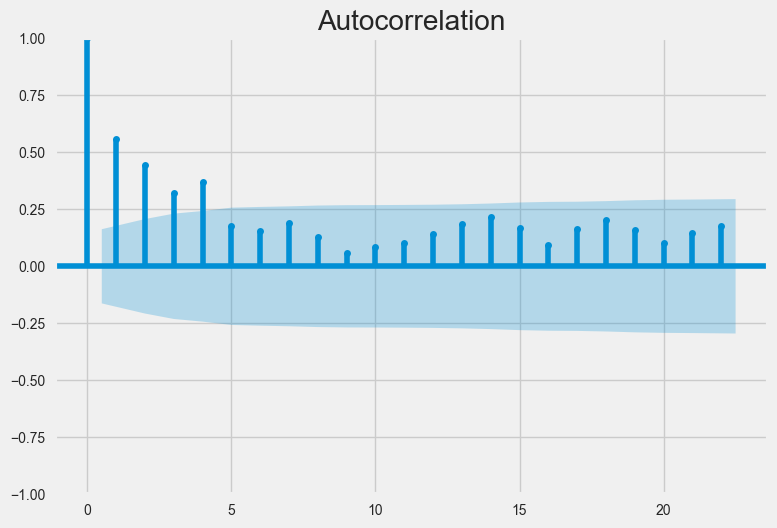

In [38]:
plot_acf(df_AR.query('center_id==55 and meal_id==1993')['num_orders_shift1']);
plt.tight_layout()

In [82]:
NUM_SHIFTS = 6
shift_columns = [f'num_orders_shift{i+1}' for i in range(NUM_SHIFTS)]
all_shift_columns = [f'num_orders_shift{i+1}' for i in range(6)]
drop_shift_columns = list(set(all_shift_columns)-set(shift_columns))
drop_id_columns = ['id']
# We don't need categorical columns which differentiate between meals or centers
drop_cat_columns = []
drop_num_columns = ['checkout_price']

num_columns = ['op_area', 'base_price']+shift_columns
cat_columns = ['center_id','meal_id','category','cuisine','city_code','region_code','center_type']
df_AR_processed = df_AR.copy()
df_AR_processed = pd.get_dummies(df_AR_processed, columns=cat_columns)
for col in num_columns: 
    col_scaler = StandardScaler().fit(df_AR_processed[col].values.reshape(-1,1))
    joblib.dump(col_scaler,f'./scalers/{col}.scaler')
    df_AR_processed[col] = col_scaler.transform(df_AR_processed[col].values.reshape(-1,1))
df_AR_processed['week'] = FunctionTransformer(encode_week).fit_transform(df_AR_processed['week'].values.reshape(-1,1))
df_AR_processed = df_AR_processed.drop(drop_num_columns + drop_cat_columns + drop_shift_columns,axis=1)

df_train_AR = df_AR_processed[df_AR['week'] <= 116]
df_test_AR = df_AR_processed[df_AR['week'] > 116]
X_train_shift = df_train_AR.drop(['num_orders','id'],axis=1)
y_train_shift = df_train_AR['num_orders']
X_test_shift = df_test_AR.drop(['num_orders','id'],axis=1)
y_test_shift = df_test_AR['num_orders']

cv_indices_shift = [
    (df_AR.query('week <= 71').index, df_AR.query('week > 71 and week <= 86').index),
    (df_AR.query('week <= 86').index, df_AR.query('week > 86 and week <= 101').index),
    (df_AR.query('week <= 101').index, df_AR.query('week > 101 and week <= 116').index)
]

In [ ]:
lr_model_shift = LinearRegression()
lr_model_shift.fit(X_train_shift,y_train_shift)
y_pred = lr_model_shift.predict(X_test_shift)
report_performance(y_test_shift,y_pred)

In [91]:
start = time.time()
lasso_model_cv_shift = Lasso(max_iter=3000)
param_grid = {
    'alpha': np.linspace(1e-3,1,num=100)
}
lasso_model_cv_shift = GridSearchCV(lasso_model_cv_shift,param_grid,cv=cv_indices_shift)
lasso_model_cv_shift.fit(X_train_shift,y_train_shift)
end = time.time()
dur = end-start
print(f'Total training time {dur}')

C:\Users\alexpc2red\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.623e+09, tolerance: 3.869e+06
  model = cd_fast.enet_coordinate_descent(
C:\Users\alexpc2red\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.916e+09, tolerance: 4.561e+06
  model = cd_fast.enet_coordinate_descent(
C:\Users\alexpc2red\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations

Total training time 2589.7451026439667


In [92]:
y_pred = lasso_model_cv_shift.predict(X_test_shift)
report_performance(y_test_shift,y_pred)

RMSE: 211.36, MAPE: 0.93
MAE: 101.47, MaxE: 11672.46
R2: 0.67


In [93]:
lasso_model_cv_shift.best_params_

{'alpha': 0.09181818181818183}

In [85]:
lasso_model_shift = Lasso(alpha=0.092)
lasso_model_shift.fit(X_train_shift,y_train_shift)
y_pred = lasso_model_shift.predict(X_test_shift)
report_performance(y_test_shift,y_pred)

RMSE: 211.37, MAPE: 0.9349
MAE: 101.49, MaxE: 11672.47
MedAE: 61.02, R2: 0.67


In [99]:
{lasso_model_shift.feature_names_in_[i]: lasso_model_shift.coef_[i] for i in range(len(lasso_model_shift.feature_names_in_))}

{'week': -3.8759829194726416,
 'base_price': -34.699557987318826,
 'emailer_for_promotion': 316.8839582105331,
 'homepage_featured': 159.61995417447258,
 'op_area': 22.78378739460924,
 'num_orders_shift1': 145.3302611280859,
 'num_orders_shift2': 45.09166805047725,
 'num_orders_shift3': 2.9057859721723522,
 'num_orders_shift4': 14.655538564640825,
 'num_orders_shift5': 22.909290855537296,
 'num_orders_shift6': 20.747873473501585,
 'center_id_10': 20.188395911435574,
 'center_id_11': 52.78089999556941,
 'center_id_13': 56.56588748618958,
 'center_id_14': -0.0,
 'center_id_17': -0.0,
 'center_id_20': -8.609127846189015,
 'center_id_23': 0.6254953731349079,
 'center_id_24': 27.69357377375416,
 'center_id_26': 0.0,
 'center_id_27': 0.0,
 'center_id_29': -0.0,
 'center_id_30': 8.1307075490478,
 'center_id_32': 0.0,
 'center_id_34': -1.9412302156122896,
 'center_id_36': -0.0,
 'center_id_39': 0.0,
 'center_id_41': -9.681511814416917,
 'center_id_42': -10.42733043431479,
 'center_id_43': 91.5

In [98]:
lasso_model_shift.feature_names_in_

array(['week', 'base_price', 'emailer_for_promotion', 'homepage_featured',
       'op_area', 'num_orders_shift1', 'num_orders_shift2',
       'num_orders_shift3', 'num_orders_shift4', 'num_orders_shift5',
       'num_orders_shift6', 'center_id_10', 'center_id_11',
       'center_id_13', 'center_id_14', 'center_id_17', 'center_id_20',
       'center_id_23', 'center_id_24', 'center_id_26', 'center_id_27',
       'center_id_29', 'center_id_30', 'center_id_32', 'center_id_34',
       'center_id_36', 'center_id_39', 'center_id_41', 'center_id_42',
       'center_id_43', 'center_id_50', 'center_id_51', 'center_id_52',
       'center_id_53', 'center_id_55', 'center_id_57', 'center_id_58',
       'center_id_59', 'center_id_61', 'center_id_64', 'center_id_65',
       'center_id_66', 'center_id_67', 'center_id_68', 'center_id_72',
       'center_id_73', 'center_id_74', 'center_id_75', 'center_id_76',
       'center_id_77', 'center_id_80', 'center_id_81', 'center_id_83',
       'center_id_86', 'c

In [94]:
report_mean_r2(df_AR[df_AR['week']>116],y_pred)

Mean r2: -29.88


In [95]:
xgb_model_shift = xgb.XGBRegressor(n_estimators=350,learning_rate=0.05,subsample=0.75)
xgb_model_shift.fit(X_train_shift,y_train_shift)
y_pred = xgb_model_shift.predict(X_test_shift)
report_performance(y_test_shift,y_pred)

RMSE: 161.98, MAPE: 0.5108
MAE: 73.04, MaxE: 9984.46
MedAE: 37.73, R2: 0.80


In [96]:
report_mean_r2(df_AR[df_AR['week']>116],y_pred)

Mean r2: -0.50


In [41]:
xgb_model_shift.save_model('./forecastmodel.json')

In [216]:
df_AR.tail(5)

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,category,...,city_code,region_code,center_type,op_area,num_orders_shift1,num_orders_shift2,num_orders_shift3,num_orders_shift4,num_orders_shift5,num_orders_shift6
456543,1271326,145,61,1543,484.09,484.09,0,0,68,Desert,...,473,77,TYPE_A,4.5,123.0,95.0,80.0,54.0,28.0,122.0
456544,1062036,145,61,2304,482.09,482.09,0,0,42,Desert,...,473,77,TYPE_A,4.5,13.0,14.0,26.0,15.0,0.0,40.0
456545,1110849,145,61,2664,237.68,321.07,0,0,501,Salad,...,473,77,TYPE_A,4.5,770.0,391.0,270.0,203.0,270.0,366.0
456546,1147725,145,61,2569,243.50,313.34,0,0,729,Salad,...,473,77,TYPE_A,4.5,811.0,447.0,432.0,284.0,161.0,419.0
456547,1361984,145,61,2490,292.03,290.03,0,0,162,Salad,...,473,77,TYPE_A,4.5,190.0,216.0,190.0,231.0,310.0,217.0


In [217]:
X_test_shift.to_csv('./processed_test_data.csv')

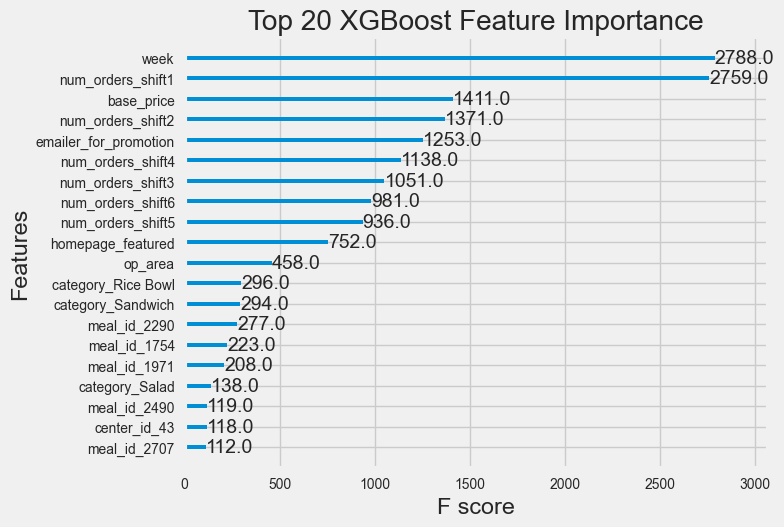

In [132]:
fig,ax = plt.subplots()
xgb.plot_importance(xgb_model_shift, ax=ax, max_num_features=20)
ax.set_title('Top 20 XGBoost Feature Importance')
plt.tight_layout()
fig.savefig('./figs/importancewithshift.pdf')

## Another ensemble model, this time one model for each center

In [112]:
NUM_SHIFTS = 6
shift_columns = [f'num_orders_shift{i+1}' for i in range(NUM_SHIFTS)]
all_shift_columns = [f'num_orders_shift{i+1}' for i in range(6)]
drop_shift_columns = list(set(all_shift_columns)-set(shift_columns))
drop_cat_columns = ['city_code', 'region_code', 'center_type']
drop_num_columns = ['op_area']
drop_id_columns_center = ['id', 'center_id', 'checkout_price']

cat_columns = ['meal_id','category','cuisine']
num_columns = ['base_price'] + shift_columns

df_AR_processed = df_AR.copy()
df_AR_processed = pd.get_dummies(df_AR_processed, columns=cat_columns)
for col in num_columns:
    df_AR_processed[col] = StandardScaler().fit_transform(df_AR_processed[col].values.reshape(-1,1))
df_AR_processed['week'] = FunctionTransformer(encode_week).fit_transform(df_AR_processed['week'].values.reshape(-1,1))
df_AR_processed = df_AR_processed.drop(drop_num_columns + drop_cat_columns + drop_shift_columns,axis=1)

df_train_AR = df_AR_processed[df_AR['week'] <= 116]
df_test_AR = df_AR_processed[df_AR['week'] > 116]
X_train_center = df_train_AR.drop('num_orders',axis=1)
y_train_center = df_train_AR['num_orders']
X_test_center = df_test_AR.drop('num_orders',axis=1)
y_test_center = df_test_AR['num_orders']

cv_indices_center = [
    (df_AR.query('week <= 71').index, df_AR.query('week > 71 and week <= 86').index),
    (df_AR.query('week <= 86').index, df_AR.query('week > 86 and week <= 101').index),
    (df_AR.query('week <= 101').index, df_AR.query('week > 101 and week <= 116').index)
]

In [31]:
X_train_center

,id,week,center_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders_shift1,num_orders_shift2,num_orders_shift3,...,category_Rice Bowl,category_Salad,category_Sandwich,category_Seafood,category_Soup,category_Starters,cuisine_Continental,cuisine_Indian,cuisine_Italian,cuisine_Thai
0,1379560,0.019231,55,136.83,-1.256048,0,0,-0.209697,-0.208260,-0.207692,...,0,0,0,0,0,0,0,0,0,1
1,1466964,0.019231,55,136.83,-1.358465,0,0,0.024415,0.025667,0.026047,...,0,0,0,0,0,0,0,0,0,1
2,1346989,0.019231,55,134.86,-1.358278,0,0,-0.179489,-0.178076,-0.177532,...,0,0,0,0,0,0,0,0,0,1
3,1338232,0.019231,55,339.50,0.518763,0,0,-0.519327,-0.517649,-0.516831,...,0,0,0,0,0,0,0,1,0,0
4,1448490,0.019231,55,243.50,-0.694746,0,0,-0.554570,-0.552863,-0.552018,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
361343,1309518,2.230769,61,473.39,0.735668,0,0,-0.584778,-0.552863,-0.345925,...,0,0,0,0,0,0,0,1,0,0
361344,1263438,2.230769,61,472.39,0.735668,0,0,-0.589812,-0.618263,-0.582178,...,0,0,0,0,0,0,0,1,0,0
361345,1003938,2.230769,61,244.44,-0.265852,0,0,1.351045,0.433154,0.294972,...,0,1,0,0,0,0,0,0,1,0
361346,1366765,2.230769,61,245.47,-0.278297,0,0,1.758851,0.397940,0.908224,...,0,1,0,0,0,0,0,0,1,0


In [115]:
def ensemble_predict_center(xtest,ensemble_model):
    y_pred = pd.Series(data=0,index=xtest.index)
    for center_id in centers:
        test_rows = xtest.query(f'center_id=={center_id}').drop(drop_id_columns_center,axis=1)
        if ensemble_model[str(center_id)] and len(test_rows) > 0:
            y_pred[test_rows.index] = ensemble_model[str(center_id)].predict(test_rows)
    return y_pred

In [73]:
lr_model_ensemble_center = {}

for center_id in centers:
    lr_model = LinearRegression()
    X_train_center_temp = X_train_center.query(f'center_id=={center_id}').drop(drop_id_columns_center,axis=1)
    if len(X_train_center_temp) > 0:
        y_train_center_temp = y_train_center[X_train_center_temp.index]
        lr_model.fit(X_train_center_temp,y_train_center_temp)
        lr_model_ensemble_center[str(center_id)] = lr_model
    else:
        lr_model_ensemble_center[str(center_id)] = None

In [74]:
y_pred = ensemble_predict_center(X_test_center,lr_model_ensemble_center)
report_performance(y_test_center,y_pred)

RMSE: 865535208120.59, MAPE: 821467232.87
MAE: 18457270658.51, MaxE: 62478591602083.31
R2: -5616724097153528832.00


In [113]:
lasso_model_ensemble_center = {}

for center_id in centers:
    lr_model = Lasso(alpha=0.092)
    X_train_center_temp = X_train_center.query(f'center_id=={center_id}').drop(drop_id_columns_center,axis=1)
    if len(X_train_center_temp) > 0:
        y_train_center_temp = y_train_center[X_train_center_temp.index]
        lr_model.fit(X_train_center_temp,y_train_center_temp)
        lasso_model_ensemble_center[str(center_id)] = lr_model
    else:
        lasso_model_ensemble_center[str(center_id)] = None

In [116]:
y_pred = ensemble_predict_center(X_test_center,lasso_model_ensemble_center)
report_performance(y_test_center,y_pred)

RMSE: 196.38, MAPE: 0.7667
MAE: 94.70, MaxE: 10655.51
MedAE: 53.74, R2: 0.71


In [117]:
xgb_model_ensemble_center = {}

for center_id in centers:
    xgb_model = xgb.XGBRegressor(n_estimators=50,learning_rate=0.3)
    X_train_center_temp = X_train_center.query(f'center_id=={center_id}').drop(drop_id_columns_center,axis=1)
    if len(X_train_center_temp) > 0:
        y_train_center_temp = y_train_center[X_train_center_temp.index]
        xgb_model.fit(X_train_center_temp,y_train_center_temp)
        xgb_model_ensemble_center[str(center_id)] = xgb_model
    else:
        xgb_model_ensemble_center[str(center_id)] = None

In [118]:
y_pred = ensemble_predict_center(X_test_center,xgb_model_ensemble_center)
report_performance(y_test_center,y_pred)

RMSE: 182.26, MAPE: 0.5716
MAE: 81.50, MaxE: 9933.71
MedAE: 40.61, R2: 0.75


## One last ensemble model, this time one model for each meal

In [107]:
NUM_SHIFTS = 6
shift_columns = [f'num_orders_shift{i+1}' for i in range(NUM_SHIFTS)]
all_shift_columns = [f'num_orders_shift{i+1}' for i in range(6)]
drop_shift_columns = list(set(all_shift_columns)-set(shift_columns))
drop_cat_columns = ['category','cuisine']
drop_num_columns = []
drop_id_columns_meal = ['id', 'meal_id']

cat_columns = ['center_id', 'city_code', 'region_code', 'center_type']
num_columns = ['op_area', 'checkout_price', 'base_price'] + shift_columns

df_AR_processed = df_AR.copy()
df_AR_processed = pd.get_dummies(df_AR_processed, columns=cat_columns)
for col in num_columns:
    df_AR_processed[col] = StandardScaler().fit_transform(df_AR_processed[col].values.reshape(-1,1))
df_AR_processed['week'] = FunctionTransformer(encode_week).fit_transform(df_AR_processed['week'].values.reshape(-1,1))
df_AR_processed = df_AR_processed.drop(drop_num_columns + drop_cat_columns + drop_shift_columns,axis=1)

df_train_AR = df_AR_processed[df_AR['week'] <= 116]
df_test_AR = df_AR_processed[df_AR['week'] > 116]
X_train_meal = df_train_AR.drop('num_orders',axis=1)
y_train_meal = df_train_AR['num_orders']
X_test_meal = df_test_AR.drop('num_orders',axis=1)
y_test_meal = df_test_AR['num_orders']

cv_indices_meal = [
    (df_AR.query('week <= 71').index, df_AR.query('week > 71 and week <= 86').index),
    (df_AR.query('week <= 86').index, df_AR.query('week > 86 and week <= 101').index),
    (df_AR.query('week <= 101').index, df_AR.query('week > 101 and week <= 116').index)
]

In [119]:
def ensemble_predict_meal(xtest,ensemble_model):
    y_pred = pd.Series(data=0,index=xtest.index)
    for meal_id in meals:
        test_rows = xtest.query(f'meal_id=={meal_id}').drop(drop_id_columns_meal,axis=1)
        if ensemble_model[str(meal_id)] and len(test_rows) > 0:
            y_pred[test_rows.index] = ensemble_model[str(meal_id)].predict(test_rows)
    return y_pred

In [108]:
lr_model_ensemble_meal = {}

for meal_id in meals:
    lr_model = LinearRegression()
    X_train_meal_temp = X_train_meal.query(f'meal_id=={meal_id}').drop(drop_id_columns_meal,axis=1)
    if len(X_train_meal_temp) > 0:
        y_train_meal_temp = y_train_meal[X_train_meal_temp.index]
        lr_model.fit(X_train_meal_temp,y_train_meal_temp)
        lr_model_ensemble_meal[str(meal_id)] = lr_model
    else:
        lr_model_ensemble_meal[str(meal_id)] = None

In [109]:
y_pred = ensemble_predict_meal(X_test_meal,lr_model_ensemble_meal)
report_performance(y_test_meal,y_pred)

NameError: name 'ensemble_predict_meal' is not defined

In [120]:
lasso_model_ensemble_meal = {}

for meal_id in meals:
    lr_model = Lasso(alpha=0.092)
    X_train_meal_temp = X_train_meal.query(f'meal_id=={meal_id}').drop(drop_id_columns_meal,axis=1)
    if len(X_train_meal_temp) > 0:
        y_train_meal_temp = y_train_meal[X_train_meal_temp.index]
        lr_model.fit(X_train_meal_temp,y_train_meal_temp)
        lasso_model_ensemble_meal[str(meal_id)] = lr_model
    else:
        lasso_model_ensemble_meal[str(meal_id)] = None

In [121]:
y_pred = ensemble_predict_meal(X_test_meal,lasso_model_ensemble_meal)
report_performance(y_test_meal,y_pred)

RMSE: 182.15, MAPE: 0.6313
MAE: 86.77, MaxE: 10528.45
MedAE: 44.83, R2: 0.75


In [122]:
xgb_model_ensemble_meal = {}

for meal_id in meals:
    xgb_model = xgb.XGBRegressor(n_estimators=50)
    X_train_meal_temp = X_train_meal.query(f'meal_id=={meal_id}').drop(drop_id_columns_meal,axis=1)
    if len(X_train_meal_temp) > 0:
        y_train_meal_temp = y_train_meal[X_train_meal_temp.index]
        xgb_model.fit(X_train_meal_temp,y_train_meal_temp)
        xgb_model_ensemble_meal[str(meal_id)] = xgb_model
    else:
        xgb_model_ensemble_meal[str(meal_id)] = None

In [123]:
y_pred = ensemble_predict_meal(X_test_meal,xgb_model_ensemble_meal)
report_performance(y_test_meal,y_pred)

RMSE: 174.99, MAPE: 0.5453
MAE: 79.13, MaxE: 10366.16
MedAE: 39.32, R2: 0.77


## Performance Analysis

In [124]:
df_perf = df[df['week']>116].copy()
df_perf['baseline_pred'] = y_pred_baseline
df_perf['lasso_shift_pred'] = lasso_model_shift.predict(X_test_shift)
df_perf['xgb_shift_pred'] = xgb_model_shift.predict(X_test_shift)

In [125]:
df_perf['lasso_center_pred'] = ensemble_predict_center(X_test_center,lasso_model_ensemble_center)
df_perf['xgb_center_pred'] = ensemble_predict_center(X_test_center,xgb_model_ensemble_center)

In [126]:
df_perf['lasso_meal_pred'] = ensemble_predict_meal(X_test_meal,lasso_model_ensemble_meal)
df_perf['xgb_meal_pred'] = ensemble_predict_meal(X_test_meal,xgb_model_ensemble_meal)

In [178]:
df_perf

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,category,...,region_code,center_type,op_area,baseline_pred,lasso_shift_pred,xgb_shift_pred,lasso_center_pred,xgb_center_pred,lasso_meal_pred,xgb_meal_pred
361348,1081540,117,55,1885,148.44,147.44,0,0,162,Beverages,...,56,TYPE_C,2.0,253.293103,224.752522,129.335251,168.721000,87.187950,136.375000,107.879730
361349,1165036,117,55,1993,148.44,148.44,0,0,135,Beverages,...,56,TYPE_C,2.0,268.275862,224.754559,169.138504,196.659747,189.189072,146.006836,208.644379
361350,1355087,117,55,2539,152.35,152.35,0,0,163,Beverages,...,56,TYPE_C,2.0,198.443478,105.961414,122.762802,141.340091,77.793694,140.709473,128.123734
361351,1145972,117,55,2139,307.49,307.49,0,0,41,Beverages,...,56,TYPE_C,2.0,21.475610,-0.323630,23.968071,24.647244,28.836872,29.509766,29.557178
361352,1011284,117,55,2631,145.50,145.50,0,0,81,Beverages,...,56,TYPE_C,2.0,51.428571,-0.132694,73.540413,33.119046,99.712379,35.796875,54.398331
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456543,1271326,145,61,1543,484.09,484.09,0,0,68,Desert,...,77,TYPE_A,4.5,63.354545,31.678464,74.527214,29.503282,73.893883,87.324219,80.169281
456544,1062036,145,61,2304,482.09,482.09,0,0,42,Desert,...,77,TYPE_A,4.5,39.821053,-25.085403,24.705643,-2.374705,41.098137,33.234375,29.986872
456545,1110849,145,61,2664,237.68,321.07,0,0,501,Salad,...,77,TYPE_A,4.5,357.170000,488.563760,360.008759,427.395949,346.437805,598.625000,403.220917
456546,1147725,145,61,2569,243.50,313.34,0,0,729,Salad,...,77,TYPE_A,4.5,454.448980,492.238902,461.195129,511.646161,434.113922,612.419922,650.786133


In [179]:
pred_keys = ['baseline_pred','lasso_shift_pred','xgb_shift_pred','lasso_center_pred','xgb_center_pred','lasso_meal_pred','xgb_meal_pred']

In [204]:
week_perf_dict = {'week': list(df_perf['week'].unique())}
for key in pred_keys:
    week_perf = []
    for week in week_perf_dict['week']:
        indices = df_perf['week']==week
        week_perf.append(np.sqrt(mean_squared_error(df_perf['num_orders'][indices],df_perf[key][indices])))
    week_perf_dict[key] = week_perf

In [206]:
week_perf_df = pd.DataFrame(week_perf_dict)

In [164]:
pred_keys_good = ['baseline_pred','lr_shift_pred','xgb_shift_pred','xgb_center_meal_pred','xgb_center_pred','xgb_meal_pred']

In [208]:
baseline_key = ['baseline_pred']
shift_keys = ['lasso_shift_pred','xgb_shift_pred']
ensemble_keys = ['xgb_center_pred','xgb_meal_pred']
xgb_keys = ['xgb_shift_pred','xgb_center_pred','xgb_meal_pred']
lasso_keys = ['lasso_shift_pred','lasso_center_pred','lasso_meal_pred']
good_keys = ['baseline_pred','lasso_meal_pred','xgb_shift_pred']

Text(0.5, 1.0, 'RMSE across all meals and centers per week on test data')

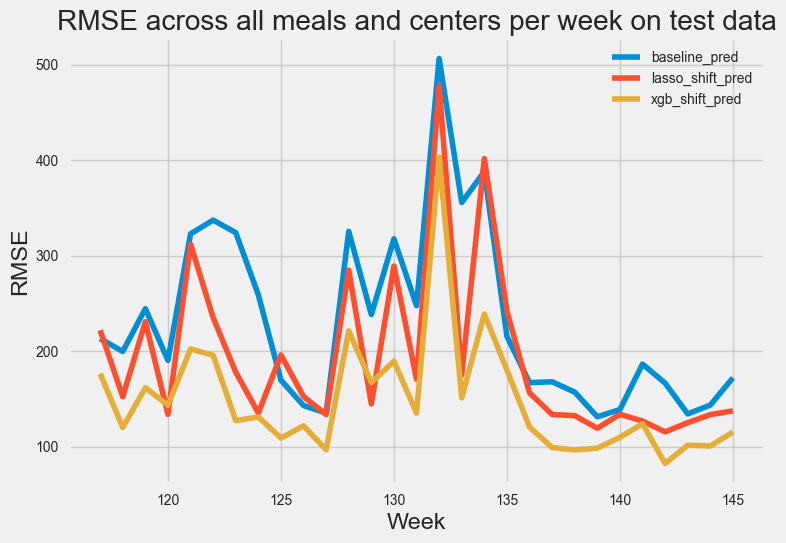

In [185]:
for key in baseline_key+shift_keys:
    plt.plot(week_perf_df['week'],week_perf_df[key])
plt.legend(baseline_key+shift_keys)
plt.xlabel('Week')
plt.ylabel('RMSE')
plt.title('RMSE across all meals and centers per week on test data')

Text(0.5, 1.0, 'RMSE across all meals and centers per week on test data')

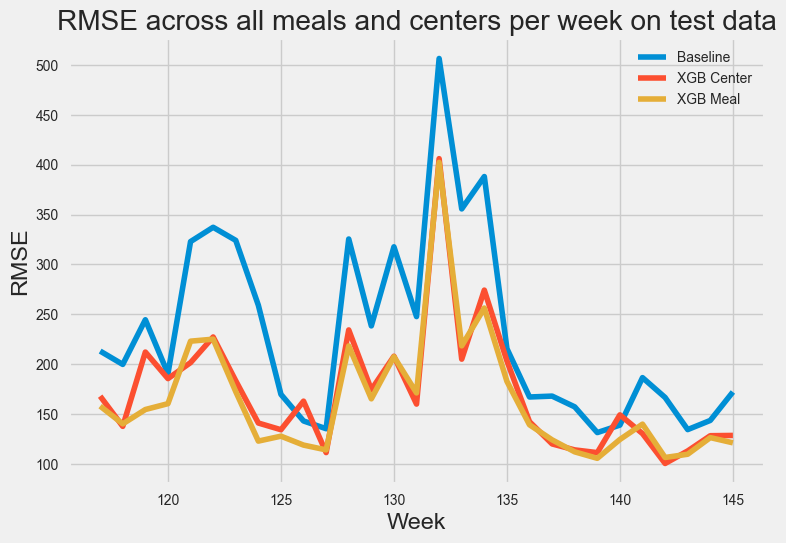

In [186]:
for key in baseline_key+ensemble_keys:
    plt.plot(week_perf_df['week'],week_perf_df[key])
plt.legend(['Baseline', 'XGB Center', 'XGB Meal'])
plt.xlabel('Week')
plt.ylabel('RMSE')
plt.title('RMSE across all meals and centers per week on test data')

Text(0.5, 1.0, 'RMSE across all meals and centers per week on test data')

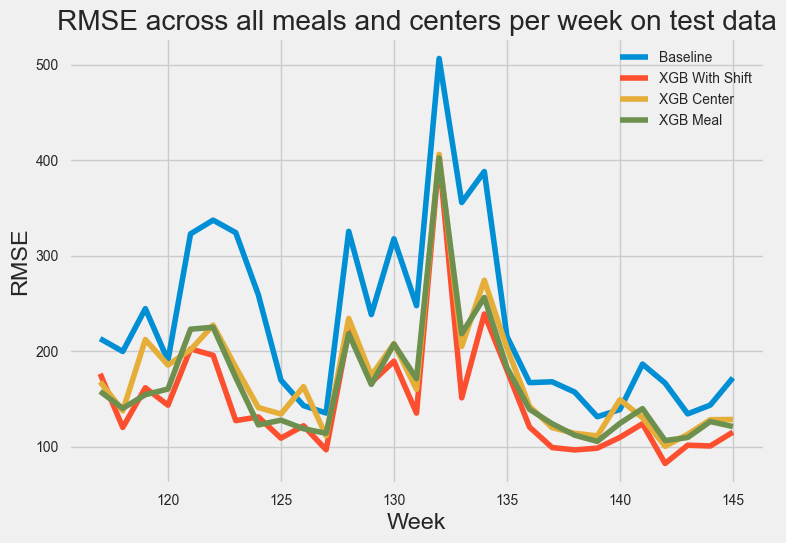

In [187]:
for key in baseline_key+xgb_keys:
    plt.plot(week_perf_df['week'],week_perf_df[key])
plt.legend(['Baseline','XGB With Shift', 'XGB Center', 'XGB Meal'])
plt.xlabel('Week')
plt.ylabel('RMSE')
plt.title('RMSE across all meals and centers per week on test data')

Text(0.5, 1.0, 'RMSE across all meals and centers per week on test data')

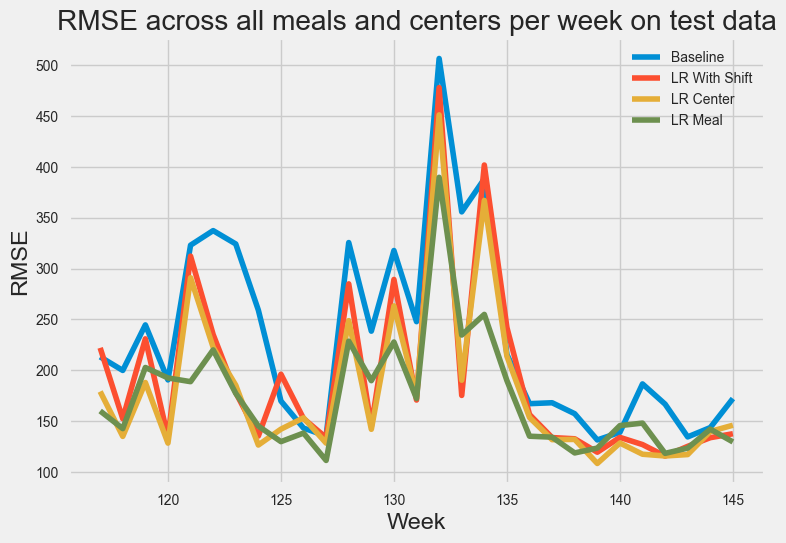

In [207]:
for key in baseline_key+lasso_keys:
    plt.plot(week_perf_df['week'],week_perf_df[key])
plt.legend(['Baseline','LR With Shift', 'LR Center', 'LR Meal'])
plt.xlabel('Week')
plt.ylabel('RMSE')
plt.title('RMSE across all meals and centers per week on test data')

Text(0.5, 1.0, 'RMSE across all meals and centers per week on test data')

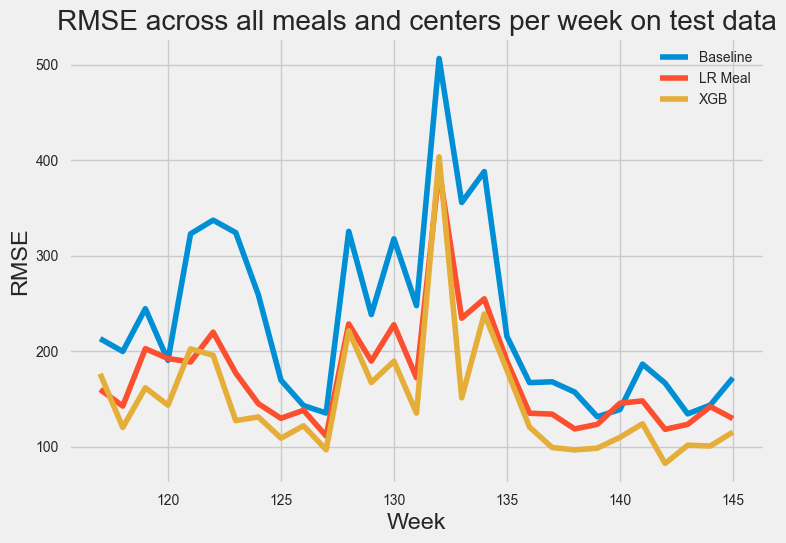

In [209]:
for key in ['baseline_pred', '']:
    plt.plot(week_perf_df['week'],week_perf_df[key])
plt.legend(['Baseline','LR Meal','XGB'])
plt.xlabel('Week')
plt.ylabel('RMSE')
plt.title('RMSE across all meals and centers per week on test data')

In [585]:
rmses = []
for key in pred_keys_good:
    rmses.append(np.sqrt(mean_squared_error(df_perf['num_orders'],df_perf[key])))

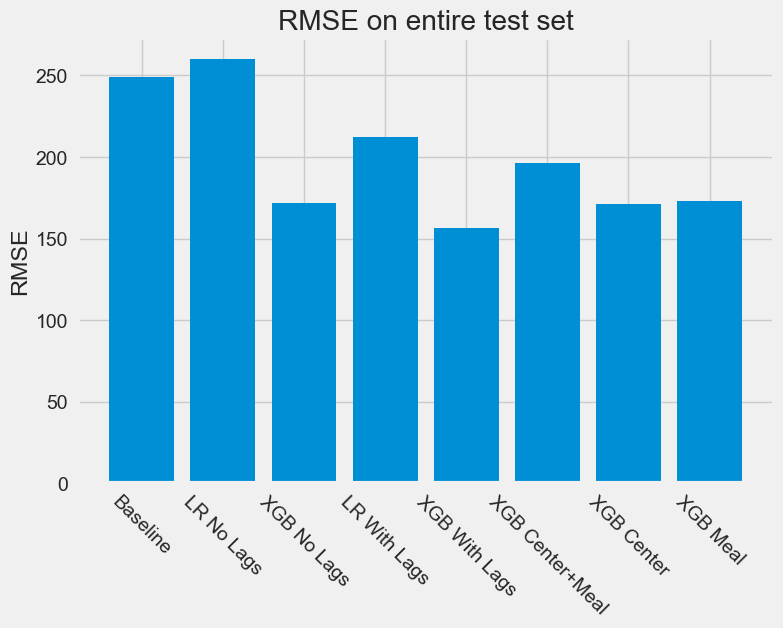

In [639]:
plt.bar(['Baseline', 'LR No Lags', 'XGB No Lags', 'LR With Lags', 'XGB With Lags', 'XGB Center+Meal', 'XGB Center', 'XGB Meal'],rmses)
plt.xticks(size=14,rotation=-45)
plt.yticks(size=14)
plt.ylabel('RMSE')
plt.title('RMSE on entire test set')
plt.savefig('./figs/rmse_pred.pdf')

In [598]:
center_perf_list = []
center_perf_columns = ['center_id','model','rmse']

for center in list(df_perf['center_id'].astype(str).unique()):
    indices = df_perf['center_id']==int(center)
    for key in pred_keys_good:
        if sum(indices) > 0:
            row = [
                center,
                key,
                np.sqrt(mean_squared_error(df_perf['num_orders'][indices],df_perf[key][indices]))
            ]
            center_perf_list.append(row)

center_perf_df = pd.DataFrame(data=center_perf_list,columns=center_perf_columns)

<AxesSubplot: xlabel='center_id', ylabel='rmse'>

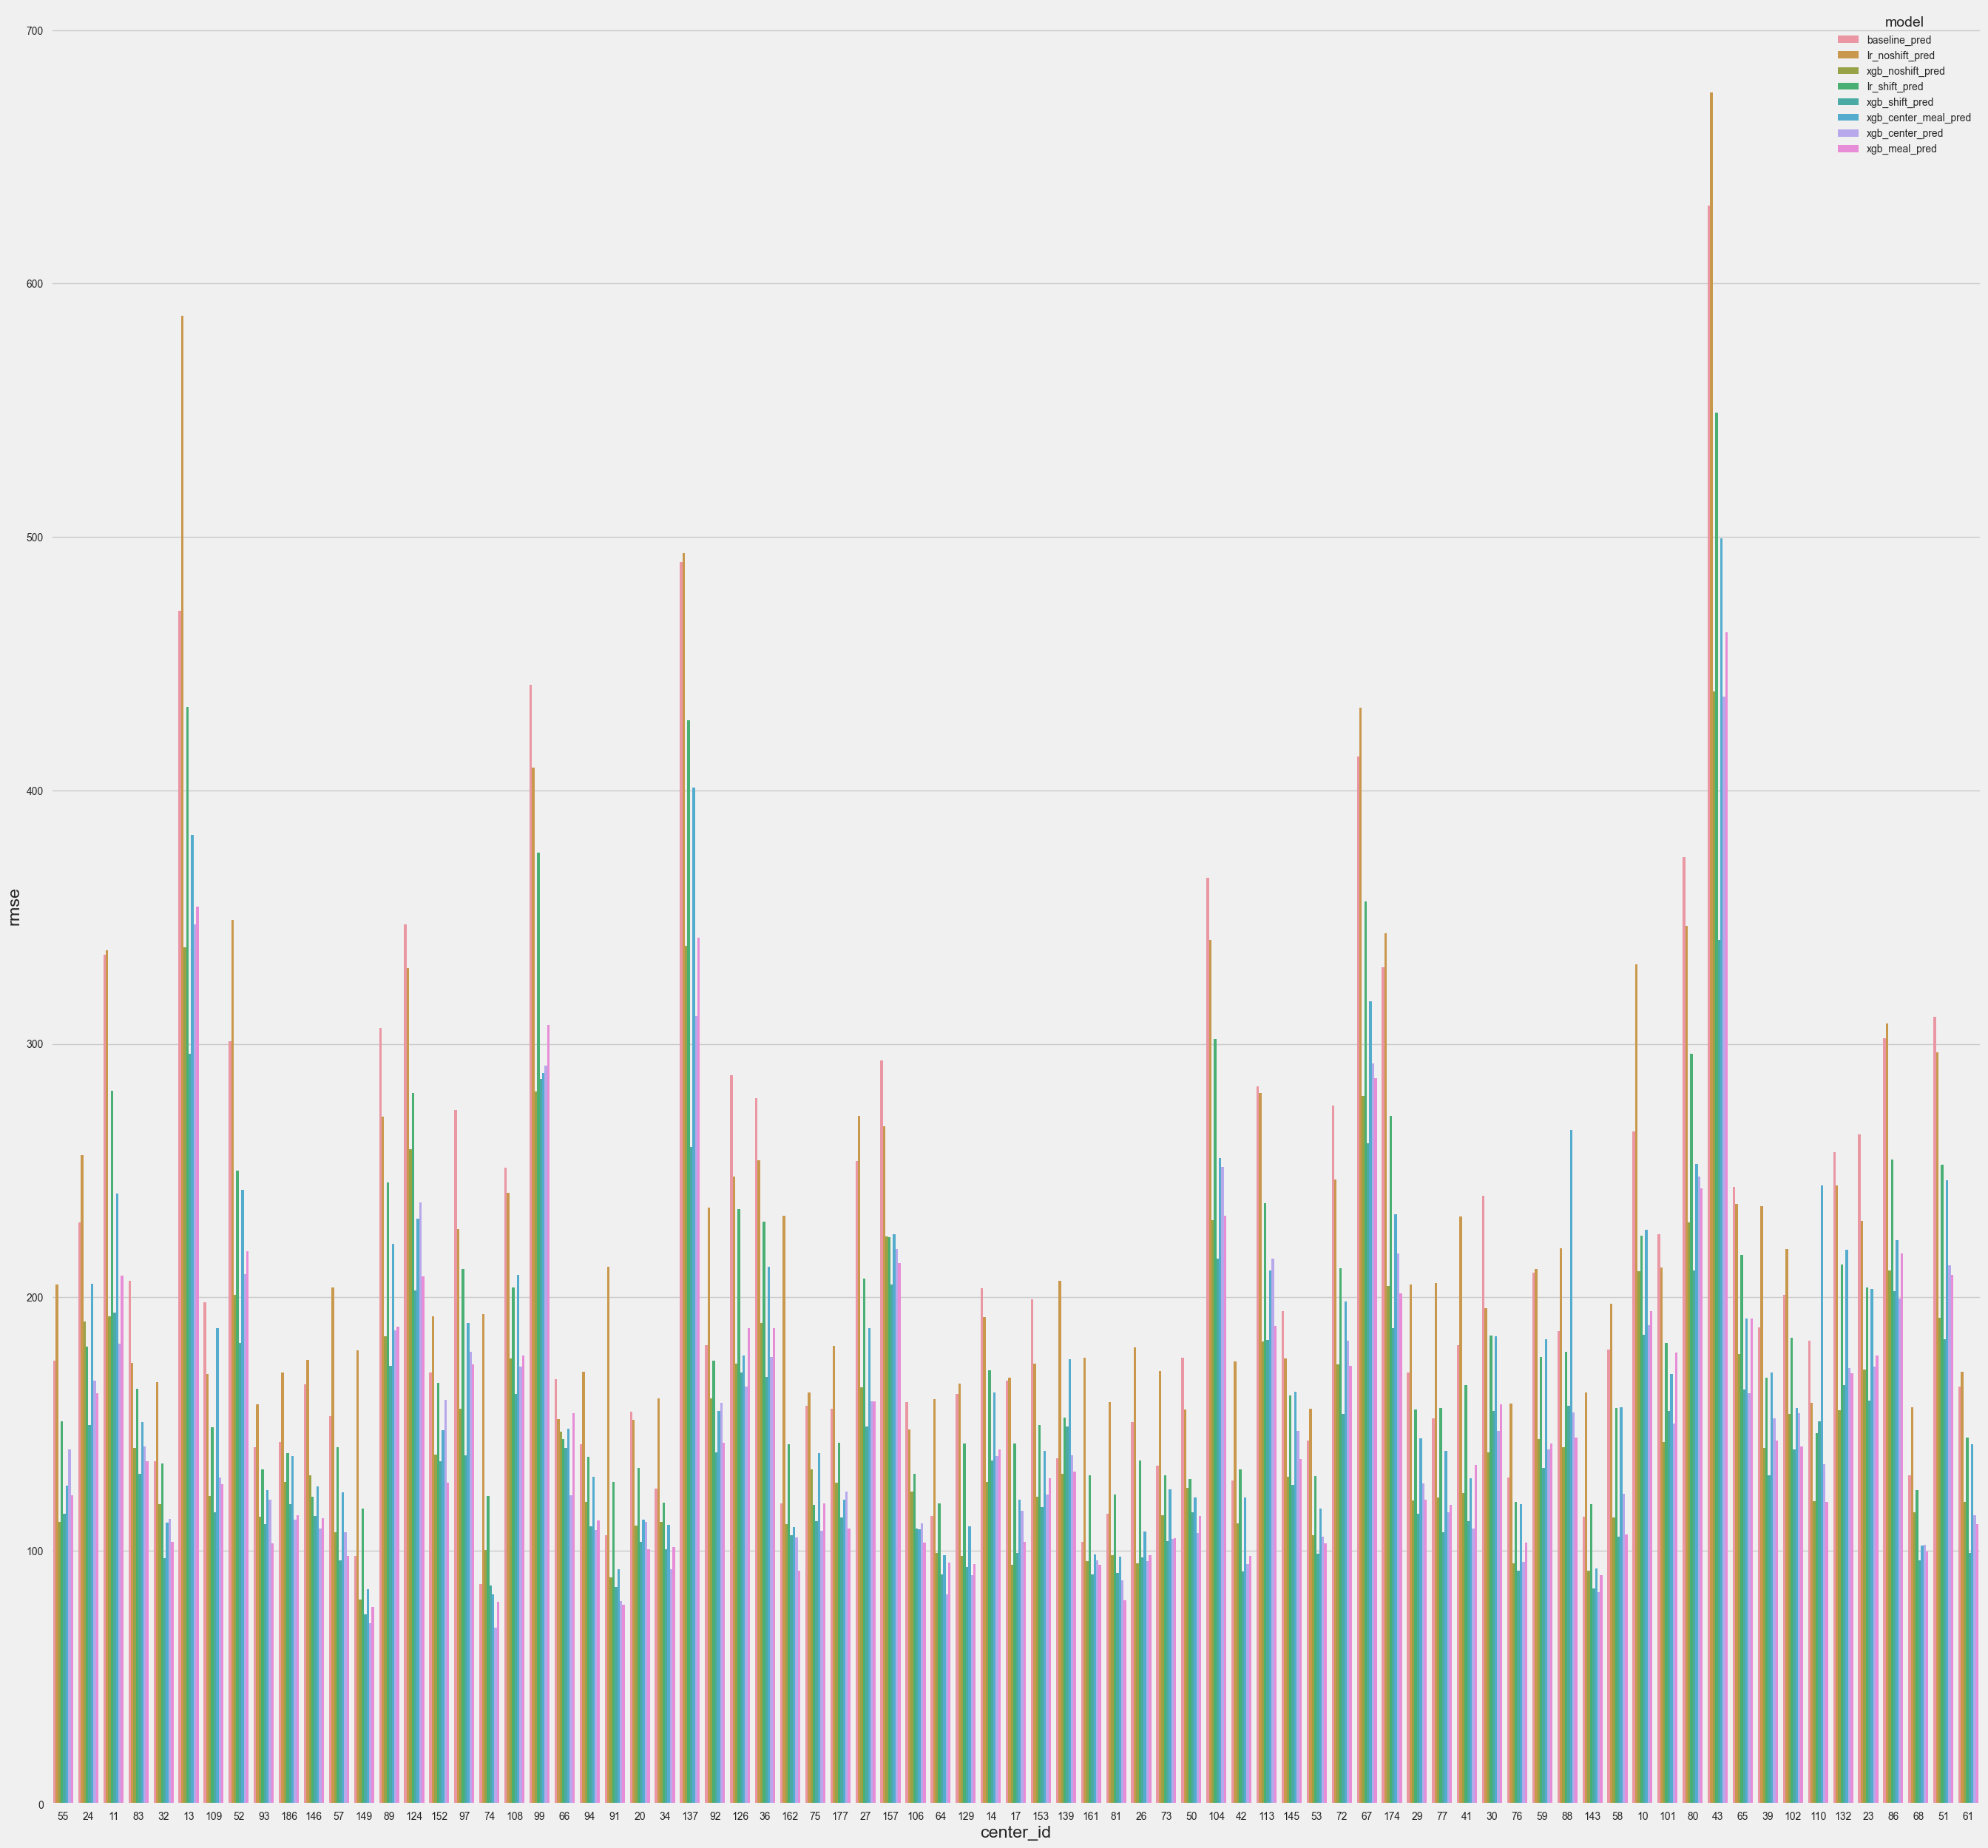

In [605]:
fig,ax = plt.subplots(figsize=(30,30))
sns.barplot(data=center_perf_df,x='center_id',y='rmse',hue='model',ax=ax)

In [612]:
category_perf_list = []
category_perf_columns = ['category','model','rmse']

for category in list(df_perf['category'].unique()):
    indices = df_perf['category']==category
    for key in pred_keys_good:
        if sum(indices) > 0:
            row = [
                category,
                key,
                np.sqrt(mean_squared_error(df_perf['num_orders'][indices],df_perf[key][indices]))
            ]
            category_perf_list.append(row)

category_perf_df = pd.DataFrame(data=category_perf_list,columns=category_perf_columns)

In [613]:
df_perf['category']

361348    Beverages
361349    Beverages
361350    Beverages
361351    Beverages
361352    Beverages
            ...    
456543       Desert
456544       Desert
456545        Salad
456546        Salad
456547        Salad
Name: category, Length: 95200, dtype: object

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
 [Text(0, 0, 'Beverages'),
  Text(1, 0, 'Rice Bowl'),
  Text(2, 0, 'Fish'),
  Text(3, 0, 'Starters'),
  Text(4, 0, 'Pasta'),
  Text(5, 0, 'Sandwich'),
  Text(6, 0, 'Extras'),
  Text(7, 0, 'Pizza'),
  Text(8, 0, 'Seafood'),
  Text(9, 0, 'Other Snacks'),
  Text(10, 0, 'Desert'),
  Text(11, 0, 'Salad'),
  Text(12, 0, 'Biryani'),
  Text(13, 0, 'Soup')])

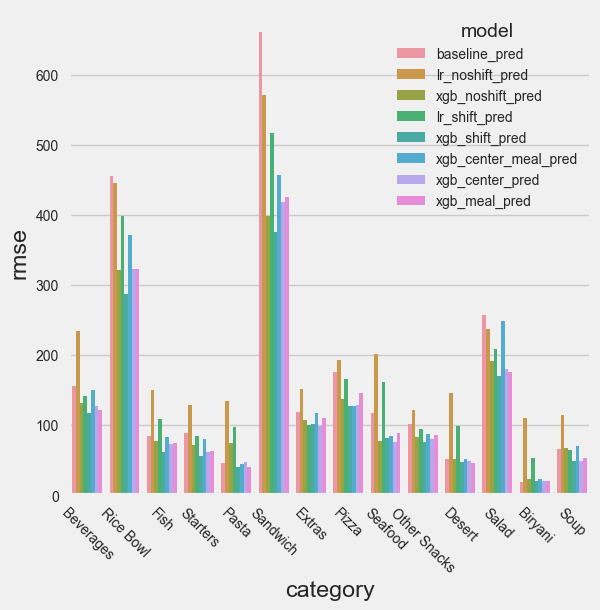

In [619]:
fig,ax = plt.subplots(figsize=(6,6))
sns.barplot(data=category_perf_df,x='category',y='rmse',hue='model',ax=ax)
plt.xticks(rotation=-45)
#plt.legend(['Baseline', 'LR No Lags', 'XGB No Lags', 'LR With Lags', 'XGB With Lags', 'XGB Center+Meal', 'XGB Center', 'XGB Meal'],title='Model')

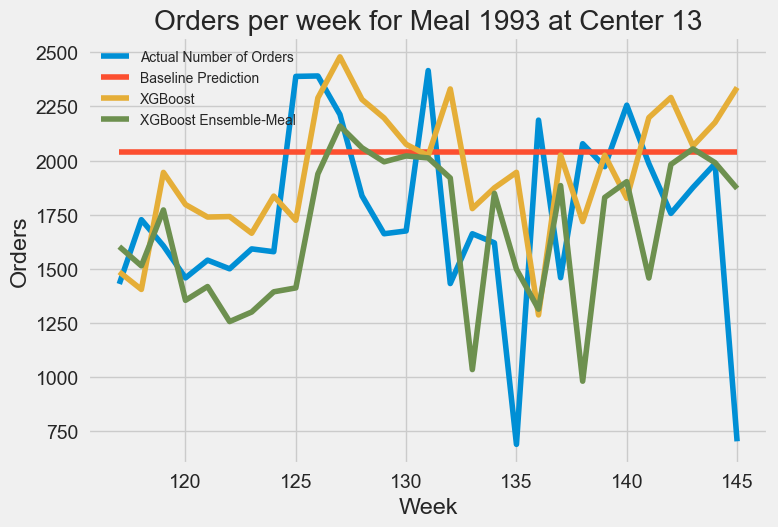

In [127]:
df_perf_sub = df_perf.query('center_id==13 and meal_id==1993')
plt.plot(df_perf_sub['week'],df_perf_sub['num_orders'])
plt.plot(df_perf_sub['week'],df_perf_sub['baseline_pred'])
plt.plot(df_perf_sub['week'],df_perf_sub['xgb_shift_pred'])
plt.plot(df_perf_sub['week'],df_perf_sub['xgb_meal_pred'])
plt.legend(['Actual Number of Orders', 'Baseline Prediction', 'XGBoost', 'XGBoost Ensemble-Meal'],loc='upper left')
plt.title('Orders per week for Meal 1993 at Center 13')
plt.xticks(size=14)
plt.yticks(size=14)
plt.xlabel('Week')
plt.ylabel('Orders')
plt.tight_layout()
plt.savefig('./figs/orders_1993_13_pred.pdf')

RMSE: 687.14, MAPE: 0.1756
MAE: 527.98, MaxE: 1563.46
MedAE: 362.46, R2: -1.24
RMSE: 456.03, MAPE: 0.1160
MAE: 321.07, MaxE: 1138.34
MedAE: 157.39, R2: 0.01
RMSE: 560.41, MAPE: 0.1457
MAE: 424.73, MaxE: 1484.97
MedAE: 294.83, R2: -0.49


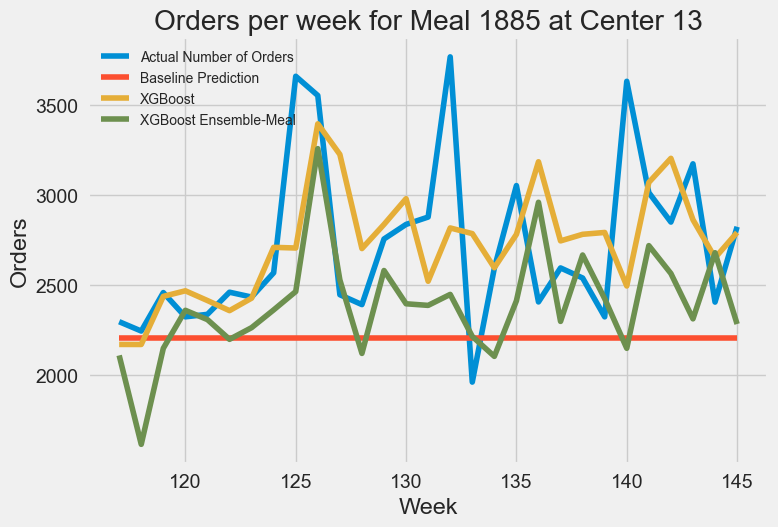

In [139]:
df_perf_sub = df_perf.query('center_id==13 and meal_id==1885')
plt.plot(df_perf_sub['week'],df_perf_sub['num_orders'])
plt.plot(df_perf_sub['week'],df_perf_sub['baseline_pred'])
plt.plot(df_perf_sub['week'],df_perf_sub['xgb_shift_pred'])
plt.plot(df_perf_sub['week'],df_perf_sub['xgb_meal_pred'])
plt.legend(['Actual Number of Orders', 'Baseline Prediction', 'XGBoost', 'XGBoost Ensemble-Meal'],loc='upper left')
plt.title('Orders per week for Meal 1885 at Center 13')
plt.xticks(size=14)
plt.yticks(size=14)
plt.xlabel('Week')
plt.ylabel('Orders')
plt.tight_layout()
plt.savefig('./figs/orders_1885_13_pred.pdf')
report_performance(df_perf_sub['num_orders'],df_perf_sub['baseline_pred'])
report_performance(df_perf_sub['num_orders'],df_perf_sub['xgb_shift_pred'])
report_performance(df_perf_sub['num_orders'],df_perf_sub['xgb_meal_pred'])

RMSE: 452.62, MAPE: 0.2648
MAE: 373.46, MaxE: 1351.78
MedAE: 370.50, R2: -0.47
RMSE: 468.59, MAPE: 0.2519
MAE: 378.51, MaxE: 1256.76
MedAE: 330.62, R2: -0.58
RMSE: 459.27, MAPE: 0.2233
MAE: 366.68, MaxE: 1097.32
MedAE: 267.65, R2: -0.51


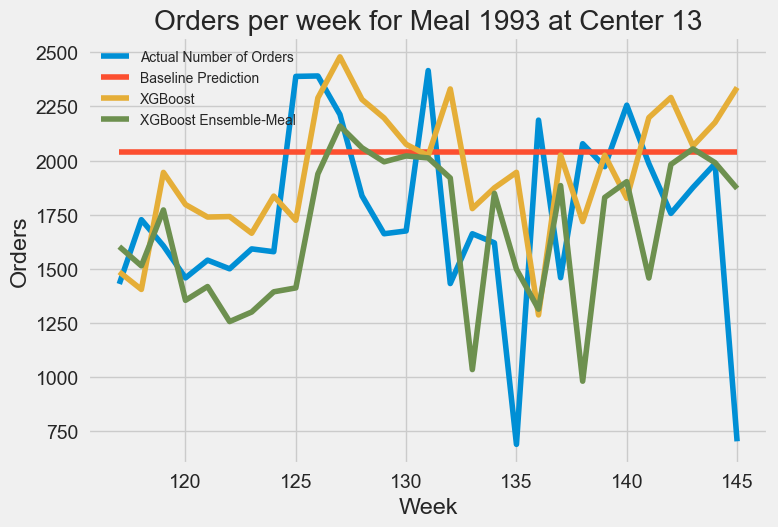

In [140]:
df_perf_sub = df_perf.query('center_id==13 and meal_id==1993')
plt.plot(df_perf_sub['week'],df_perf_sub['num_orders'])
plt.plot(df_perf_sub['week'],df_perf_sub['baseline_pred'])
plt.plot(df_perf_sub['week'],df_perf_sub['xgb_shift_pred'])
plt.plot(df_perf_sub['week'],df_perf_sub['xgb_meal_pred'])
plt.legend(['Actual Number of Orders', 'Baseline Prediction', 'XGBoost', 'XGBoost Ensemble-Meal'],loc='upper left')
plt.title('Orders per week for Meal 1993 at Center 13')
plt.xticks(size=14)
plt.yticks(size=14)
plt.xlabel('Week')
plt.ylabel('Orders')
plt.tight_layout()
plt.savefig('./figs/orders_1993_13_pred.pdf')
report_performance(df_perf_sub['num_orders'],df_perf_sub['baseline_pred'])
report_performance(df_perf_sub['num_orders'],df_perf_sub['xgb_shift_pred'])
report_performance(df_perf_sub['num_orders'],df_perf_sub['xgb_meal_pred'])

RMSE: 127.53, MAPE: 1.1844
MAE: 117.79, MaxE: 213.29
MedAE: 130.29, R2: -4.29
RMSE: 67.84, MAPE: 0.5837
MAE: 56.63, MaxE: 185.18
MedAE: 57.82, R2: -0.50
RMSE: 58.57, MAPE: 0.4220
MAE: 47.38, MaxE: 144.92
MedAE: 45.57, R2: -0.12


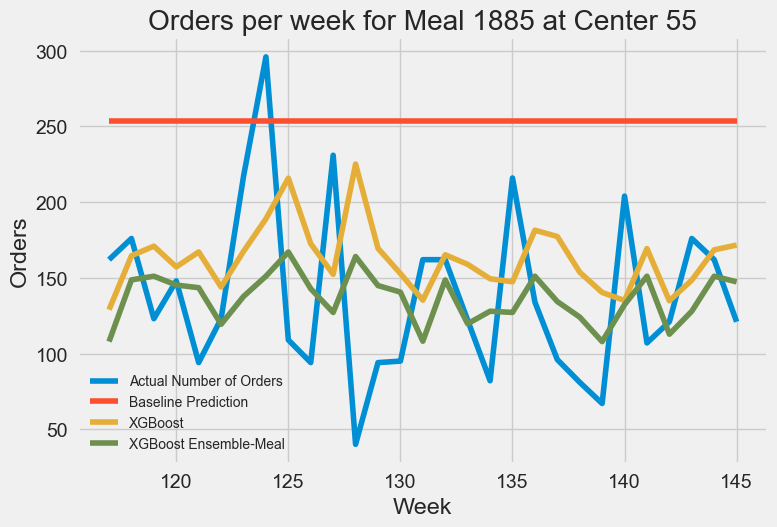

In [138]:
df_perf_sub = df_perf.query('center_id==55 and meal_id==1885')
plt.plot(df_perf_sub['week'],df_perf_sub['num_orders'])
plt.plot(df_perf_sub['week'],df_perf_sub['baseline_pred'])
plt.plot(df_perf_sub['week'],df_perf_sub['xgb_shift_pred'])
plt.plot(df_perf_sub['week'],df_perf_sub['xgb_meal_pred'])
plt.legend(['Actual Number of Orders', 'Baseline Prediction', 'XGBoost', 'XGBoost Ensemble-Meal'],loc='lower left')
plt.title('Orders per week for Meal 1885 at Center 55')
plt.xticks(size=14)
plt.yticks(size=14)
plt.xlabel('Week')
plt.ylabel('Orders')
plt.tight_layout()
plt.savefig('./figs/orders_1885_55_pred.pdf')
report_performance(df_perf_sub['num_orders'],df_perf_sub['baseline_pred'])
report_performance(df_perf_sub['num_orders'],df_perf_sub['xgb_shift_pred'])
report_performance(df_perf_sub['num_orders'],df_perf_sub['xgb_meal_pred'])

In [689]:
df_perf[(df_perf['xgb_shift_pred'] - df_perf['num_orders']).abs() > 5e3]

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,category,...,lr_noshift_pred,xgb_noshift_pred,lr_shift_pred,xgb_shift_pred,lr_center_meal_pred,xgb_center_meal_pred,lr_center_pred,xgb_center_pred,lr_meal_pred,xgb_meal_pred
410780,1012405,132,13,1971,186.30,323.04,1,1,8979,Sandwich,...,1364.648438,2822.784912,1041.347427,2335.194824,2688.766291,2796.087402,1481.347656,2422.221191,2242.564453,1844.459473
411625,1352889,132,137,1971,171.72,316.22,1,1,11056,Sandwich,...,1218.023438,3720.329834,1711.555191,4854.658691,3362.629610,2827.444092,2076.121094,3828.949707,2457.048828,3459.076416
412745,1209098,132,67,1971,170.78,310.40,1,1,9019,Sandwich,...,1172.992188,3590.184326,1006.664368,3575.709229,2967.902554,2787.766113,1290.500000,2494.003906,2248.697266,2686.582031
413351,1346216,132,43,1971,204.70,324.04,1,1,13150,Sandwich,...,1309.148438,3244.885254,1488.629288,4996.794434,4894.510740,2586.037598,2496.535156,3313.383057,2618.916016,2591.587158


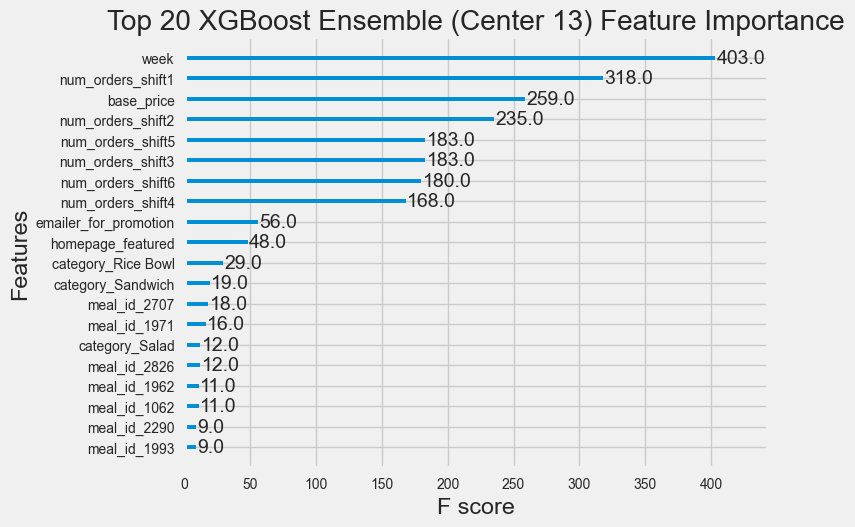

In [697]:
fig,ax = plt.subplots()
xgb.plot_importance(xgb_model_ensemble_center['13'], ax=ax, max_num_features=20)
ax.set_title('Top 20 XGBoost Ensemble (Center 13) Feature Importance')
plt.tight_layout()
fig.savefig('./figs/importanceensemble.pdf')